In [1]:
import pickle
import numpy as np
import pandas as pd

from keras.models import Sequential,Model
from keras.layers.embeddings import Embedding
from keras.layers import Input,Activation,Dense,Permute,Dropout,add,concatenate,dot,LSTM

In [2]:
train_file_path = "C:\\Drives\\Drive F\\Python\\Dataset\\UPDATED_NLP_COURSE\\UPDATED_NLP_COURSE\\06-Deep-Learning\\train_qa.txt"

with open(train_file_path,'rb') as f:
    train_data = pickle.load(f)   

In [3]:
test_file_path = "C:\\Drives\\Drive F\\Python\\Dataset\\UPDATED_NLP_COURSE\\UPDATED_NLP_COURSE\\06-Deep-Learning\\test_qa.txt"

with open(test_file_path,'rb') as f:
    test_data = pickle.load(f)   

In [4]:
len(train_data)

10000

In [5]:
len(test_data)

1000

In [6]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [7]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [8]:
set(train_data[0][0])

{'.',
 'Mary',
 'Sandra',
 'bathroom',
 'bedroom',
 'journeyed',
 'moved',
 'the',
 'to'}

In [9]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [10]:
train_data[0][2]

'no'

In [11]:
complete_data = train_data + test_data

In [12]:
vocab = set()

for story, question, answer in complete_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [13]:
vocab.add('yes')
vocab.add('no')

In [14]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [15]:
vocab_size = len(vocab) + 1 # For keras pad sequence placeholder

In [16]:
complete_story_len = [len(data[0]) for data in complete_data]
max_story_len = max(complete_story_len)
max_story_len

156

In [17]:
complete_question_len = [len(data[1]) for data in complete_data]
max_question_len = max(complete_question_len)
max_question_len

6

In [18]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [19]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)
tokenizer.word_index

{'got': 1,
 'bathroom': 2,
 'bedroom': 3,
 'went': 4,
 'dropped': 5,
 'the': 6,
 '?': 7,
 'mary': 8,
 'grabbed': 9,
 'back': 10,
 'yes': 11,
 'apple': 12,
 'is': 13,
 'daniel': 14,
 'there': 15,
 '.': 16,
 'up': 17,
 'hallway': 18,
 'took': 19,
 'milk': 20,
 'journeyed': 21,
 'football': 22,
 'discarded': 23,
 'travelled': 24,
 'left': 25,
 'sandra': 26,
 'to': 27,
 'kitchen': 28,
 'no': 29,
 'office': 30,
 'picked': 31,
 'put': 32,
 'in': 33,
 'moved': 34,
 'down': 35,
 'garden': 36,
 'john': 37}

In [20]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [21]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [22]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [23]:
len(train_story_text)

10000

In [24]:
len(train_story_seq)

10000

In [25]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    '''
    INPUT: 
    
    data: consisting of Stories,Queries,and Answers
    word_index: word index dictionary from tokenizer
    max_story_len: the length of the longest story (used for pad_sequences function)
    max_question_len: length of the longest question (used for pad_sequences function)


    OUTPUT:
    
    Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
    answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
    output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.
    
    Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
    '''
    
    
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        #
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [26]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [27]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [28]:
inputs_test

array([[ 0,  0,  0, ...,  6,  3, 16],
       [ 0,  0,  0, ...,  6, 36, 16],
       [ 0,  0,  0, ...,  6, 36, 16],
       ...,
       [ 0,  0,  0, ...,  6, 12, 16],
       [ 0,  0,  0, ...,  6, 36, 16],
       [ 0,  0,  0, ..., 12, 15, 16]])

In [29]:
queries_test

array([[13, 37, 33,  6, 28,  7],
       [13, 37, 33,  6, 28,  7],
       [13, 37, 33,  6, 36,  7],
       ...,
       [13,  8, 33,  6,  3,  7],
       [13, 26, 33,  6, 36,  7],
       [13,  8, 33,  6, 36,  7]])

In [30]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
       497.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0., 503.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [32]:
tokenizer.word_index['yes']

11

In [33]:
tokenizer.word_index['no']

29

In [34]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [35]:
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

# This encoder will output:
# (samples, story_maxlen, embedding_dim)

In [36]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

In [37]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

In [38]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [39]:
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [40]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

In [41]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [42]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [43]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)  # (samples, 32)

In [44]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

In [45]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 156)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 64)     2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
______________________________________________________________________________________________

In [47]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=100,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/100
313/313 [==============================] - 58s 27ms/step - loss: 1.1392 - accuracy: 0.4912 - val_loss: 0.6948 - val_accuracy: 0.4970
Epoch 2/100
313/313 [==============================] - 7s 21ms/step - loss: 0.7033 - accuracy: 0.4976 - val_loss: 0.6957 - val_accuracy: 0.5030
Epoch 3/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6963 - accuracy: 0.5054 - val_loss: 0.6935 - val_accuracy: 0.5030
Epoch 4/100
313/313 [==============================] - 7s 24ms/step - loss: 0.6948 - accuracy: 0.4991 - val_loss: 0.6942 - val_accuracy: 0.5030
Epoch 5/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6951 - accuracy: 0.4941 - val_loss: 0.6938 - val_accuracy: 0.5030
Epoch 6/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6953 - accuracy: 0.4810 - val_loss: 0.6934 - val_accuracy: 0.4970
Epoch 7/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6946 - accuracy: 0.5000 - val_loss: 0.6972 - val_accuracy

In [48]:
filename = 'chatbot_100_epochs.h5'
model.save(filename)

C:\Users\koppu\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


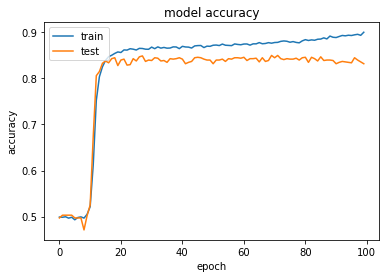

In [49]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


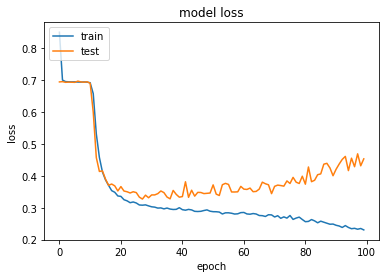

In [67]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
pred_results = model.predict(([inputs_test, queries_test]))

In [51]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [52]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [53]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [66]:
print("True Test Answer from Data is :",test_data[0][2])

True Test Answer from Data is : no


In [65]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is : ", k)
print(f"Probability of certainty : {int(pred_results[0][val_max]*100)} %")

Predicted answer is :  no
Probability of certainty : 99 %


## Writing Your Own Stories and Questions

Remember you can only use words from the existing vocab

In [68]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [69]:
# Note the whitespace of the periods
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [70]:
my_question = "Is the football in the garden ?"

In [71]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [72]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [73]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [74]:
pred_results = model.predict(([ my_story, my_ques]))

In [75]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is : ", k)
print(f"Probability of certainty : {int(pred_results[0][val_max]*100)} %")

Predicted answer is :  yes
Probability of certainty : 99 %
